# Лабораторная работа №6

In [10]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


**Задание**

1. Выберите набор данных (датасет) для решения задачи классификации или регресии.

2. В случае необходимости проведите удаление или заполнение пропусков и кодирование категориальных признаков.

3. С использованием метода train_test_split разделите выборку на обучающую и тестовую.

4. Обучите следующие ансамблевые модели:

- одну из моделей группы стекинга.
- модель многослойного персептрона. По желанию, вместо библиотеки scikit-learn возможно использование библиотек TensorFlow, PyTorch или других аналогичных библиотек.
- двумя методами на выбор из семейства МГУА (один из линейных методов COMBI / MULTI + один из нелинейных методов MIA / RIA) с использованием библиотеки gmdh.  
*В настоящее время библиотека МГУА не позволяет решать задачу классификации !!!*

5. Оцените качество моделей с помощью одной из подходящих для задачи метрик. Сравните качество полученных моделей.

6. В телегамм-канале потока ИУ5 в теме ТМО_МГУА напишите обратную связь по использованию библиотеки gmdh:

- обнаруженные баги с приложением скриншотов ошибок, за каждый найденный баг +1 балл на экзамене;
- опечатки в документации или учебном пособии МГУА;
- возникшие вопросы или трудности при установке и использовании библиотеки;
- любая другая информация (критика, предложения по улучшению и тд).

In [ ]:
# !pip3 install heamy

## Импорт библиотек

In [13]:
import numpy as np
import pandas as pd
from typing import Dict, Tuple
from scipy import stats

from sklearn.linear_model import LinearRegression
from sklearn.model_selection import cross_val_score
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsRegressor
from sklearn.model_selection import GridSearchCV, RandomizedSearchCV
from sklearn.metrics import confusion_matrix
from sklearn.tree import DecisionTreeRegressor, export_graphviz

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import ExtraTreesRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.preprocessing import StandardScaler
from sklearn.neural_network import MLPRegressor
from sklearn.metrics import mean_absolute_error, mean_squared_error, mean_squared_log_error, median_absolute_error, r2_score

from heamy.estimator import Regressor
from heamy.pipeline import ModelsPipeline
from heamy.dataset import Dataset

import seaborn as sns
import matplotlib.pyplot as plt
%matplotlib inline

NOTE: estimator.py  
from inspect import ~~getargspec~~ getfullargspec

## Загрузка датасета

| Признак            | Описание |
|----------------------|-------------|
| Square_Footage     | The size of the house in square feet. Larger homes typically have higher prices. |
| Num_Bedrooms       | The number of bedrooms in the house. More bedrooms generally increase the value of a home. |
| Num_Bathrooms      | The number of bathrooms in the house. Houses with more bathrooms are typically priced higher. |
| Year_Built         | The year the house was built. Older houses may be priced lower due to wear and tear. |
| Lot_Size           | The size of the lot the house is built on, measured in acres. Larger lots tend to add value to a property. |
| Garage_Size        | The number of cars that can fit in the garage. Houses with larger garages are usually more expensive. |
| Neighborhood_Quality | A rating of the neighborhood’s quality on a scale of 1-10, where 10 indicates a high-quality neighborhood. Better neighborhoods usually command higher prices. |
| House_Price (Target Variable) | The price of the house, which is the dependent variable you aim to predict. |


In [50]:
data = pd.read_csv("/content/drive/MyDrive/Colab Notebooks/house_price_dataset.csv")
data.head()

,Square_Footage,Num_Bedrooms,Num_Bathrooms,Year_Built,Lot_Size,Garage_Size,Neighborhood_Quality,House_Price
0,1360,2,1,1981,0.599637,0,5,2.623829e+05
1,4272,3,3,2016,4.753014,1,6,9.852609e+05
2,3592,1,2,2016,3.634823,0,9,7.779774e+05
3,966,1,2,1977,2.730667,1,8,2.296989e+05
4,4926,2,1,1993,4.699073,0,8,1.041741e+06


## Первичный анализ датасета

In [15]:
data.isnull().sum() # --> нет пропусков в данных

,0
Square_Footage,0
Num_Bedrooms,0
Num_Bathrooms,0
Year_Built,0
Lot_Size,0
Garage_Size,0
Neighborhood_Quality,0
House_Price,0


In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 1000 entries, 0 to 999
Data columns (total 8 columns):
 #   Column                Non-Null Count  Dtype  
---  ------                --------------  -----  
 0   Square_Footage        1000 non-null   int64  
 1   Num_Bedrooms          1000 non-null   int64  
 2   Num_Bathrooms         1000 non-null   int64  
 3   Year_Built            1000 non-null   int64  
 4   Lot_Size              1000 non-null   float64
 5   Garage_Size           1000 non-null   int64  
 6   Neighborhood_Quality  1000 non-null   int64  
 7   House_Price           1000 non-null   float64
dtypes: float64(2), int64(6)
memory usage: 62.6 KB


In [ ]:
data.nunique()

,0
Square_Footage,894
Num_Bedrooms,5
Num_Bathrooms,3
Year_Built,73
Lot_Size,1000
Garage_Size,3
Neighborhood_Quality,10
House_Price,1000


In [18]:
data.describe().T

,count,mean,std,min,25%,50%,75%,max
Square_Footage,1000.0,2815.422000,1255.514921,503.000000,1749.500000,2862.500000,3849.500000,4.999000e+03
Num_Bedrooms,1000.0,2.990000,1.427564,1.000000,2.000000,3.000000,4.000000,5.000000e+00
Num_Bathrooms,1000.0,1.973000,0.820332,1.000000,1.000000,2.000000,3.000000,3.000000e+00
Year_Built,1000.0,1986.550000,20.632916,1950.000000,1969.000000,1986.000000,2004.250000,2.022000e+03
Lot_Size,1000.0,2.778087,1.297903,0.506058,1.665946,2.809740,3.923317,4.989303e+00
Garage_Size,1000.0,1.022000,0.814973,0.000000,0.000000,1.000000,2.000000,2.000000e+00
Neighborhood_Quality,1000.0,5.615000,2.887059,1.000000,3.000000,6.000000,8.000000,1.000000e+01
House_Price,1000.0,618861.018647,253568.058375,111626.853424,401648.228909,628267.291129,827141.277637,1.108237e+06


## Подготовка датасета

<Axes: >

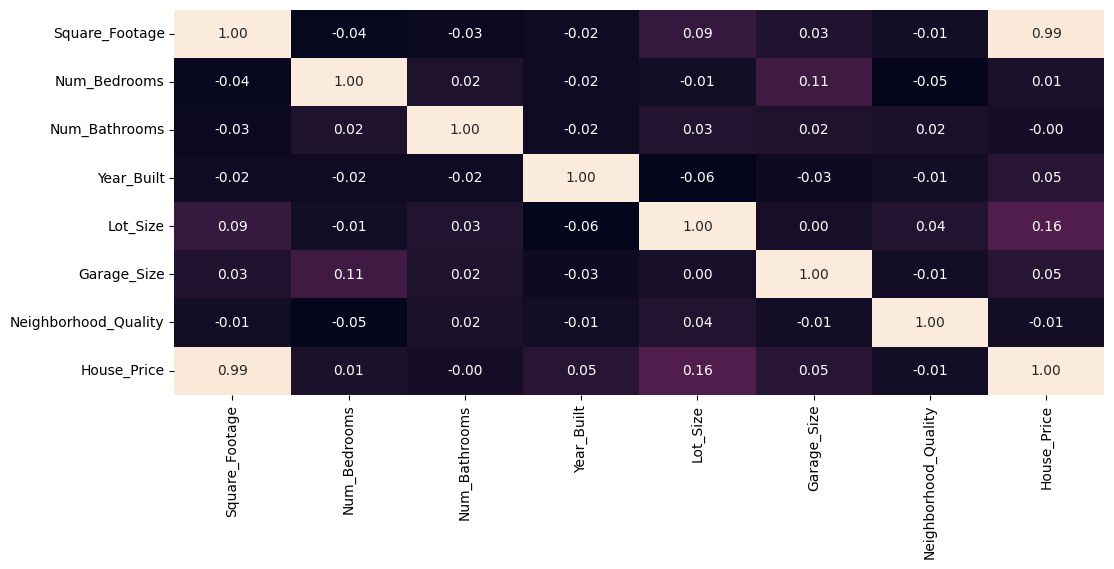

In [19]:
fig, ax = plt.subplots(figsize=(12,5))
sns.heatmap(data.corr(method='pearson'), ax=ax, annot=True, cbar=False, fmt='.2f')

In [51]:
from datetime import datetime

current_year = datetime.now().year

# Замена Year_Built на возраст дома в годах
data['House_Age'] = current_year - data['Year_Built']

data.drop('Year_Built', axis=1, inplace=True)

data.head()

,Square_Footage,Num_Bedrooms,Num_Bathrooms,Lot_Size,Garage_Size,Neighborhood_Quality,House_Price,House_Age
0,1360,2,1,0.599637,0,5,2.623829e+05,44
1,4272,3,3,4.753014,1,6,9.852609e+05,9
2,3592,1,2,3.634823,0,9,7.779774e+05,9
3,966,1,2,2.730667,1,8,2.296989e+05,48
4,4926,2,1,4.699073,0,8,1.041741e+06,32


<Axes: >

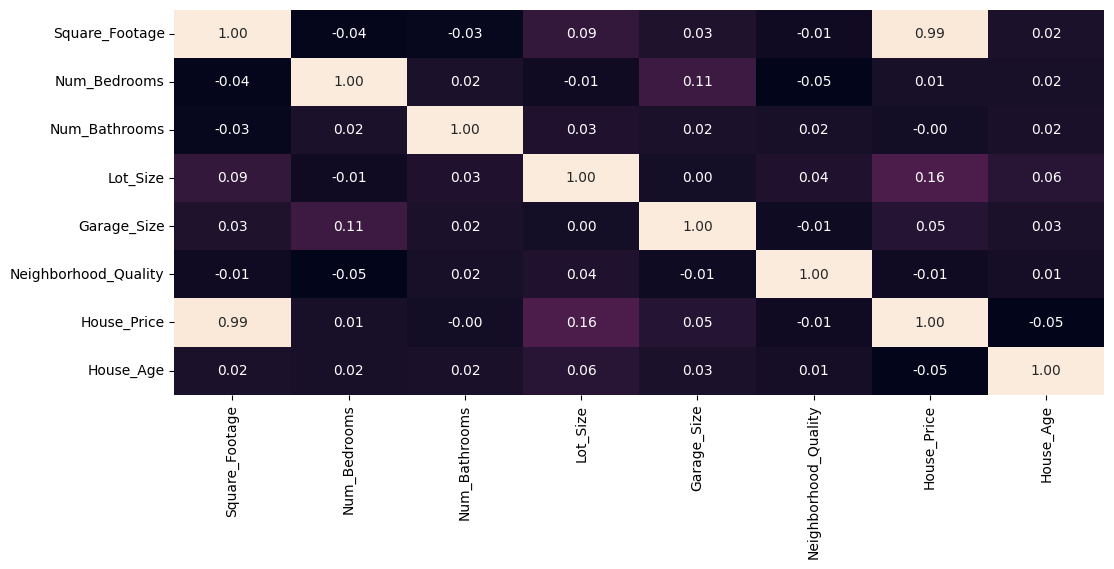

In [52]:
fig, ax = plt.subplots(figsize=(12,5))
sns.heatmap(data.corr(method='pearson'), ax=ax, annot=True, cbar=False, fmt='.2f')

## Разделение выборки

In [53]:
X = data.drop(['House_Price'], axis=1)
y = data['House_Price']

X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2, random_state=10)

## Масштабирование данных
Масштабирование предполагает изменение диапазона измерения величины.

In [54]:
scaler = StandardScaler()

X_train = scaler.fit_transform(X_train)
X_test = scaler.transform(X_test)

## Обучение и оценка моделей

## Оценка качества моделей

1. **Mean absolute error** - средняя абсолютная ошибка

    $MAE(y,\hat{y}) = \frac{1}{N} \cdot \sum\limits_{i=1}^N \lvert  y_i - \hat{y_i} \rvert $  
    где:
    - $y$ - истинное значение целевого признака
    - $\hat{y}$ - предсказанное значение целевого признака
    - $N$ - размер тестовой выборки

    *Чем ближе значение к нулю, тем лучше качество регрессии. Основная проблема метрики состоит в том, что она не нормирована.*

2. **Mean squared error** - средняя квадратичная ошибка, **Root mean squared error** - корень из средней квадратичной ошибки

    $$MSE(y,\hat{y}) = \frac{1}{N} \cdot \sum\limits_{i=1}^N ( y_i - \hat{y_i} )^2 $$  
    где:
    - $y$ - истинное значение целевого признака
    - $\hat{y}$ - предсказанное значение целевого признака
    - $N$ - размер тестовой выборки

    $$RMSE(y,\hat{y}) = \sqrt{MSE(y,\hat{y})} = \sqrt{ \frac{1}{N} \cdot \sum\limits_{i=1}^N ( y_i - \hat{y_i} )^2} $$

3. **Median absolute error**

    $MedAE(y,\hat{y}) = median( \lvert  y_1 - \hat{y_1} \rvert, \dots, \lvert  y_N - \hat{y_N} \rvert)$

    Метрика интересна тем, что является устойчивой к выбросам в данных.

4. **Метрика $R^2$ или коэффициент детерминации**

    $R^2(y,\hat{y}) = 1 - \frac{\sum\limits_{i=1}^N ( y_i - \hat{y_i} )^2}{\sum\limits_{i=1}^N ( y_i - \overline{y_i} )^2} $  
    где:
    - $y$ - истинное значение целевого признака
    - $\hat{y}$ - предсказанное значение целевого признака
    - $N$ - размер тестовой выборки
    - $\overline{y_i} = \frac{1}{N} \cdot \sum\limits_{i=1}^N y_i $

    Коэффициент детерминации для модели с константой принимает значения от 0 до 1. Чем ближе значение коэффициента к 1, тем сильнее зависимость. При оценке регрессионных моделей это интерпретируется как соответствие модели данным. Для приемлемых моделей предполагается, что коэффициент детерминации должен быть хотя бы не меньше 50 % (в этом случае коэффициент множественной корреляции превышает по модулю 70 %). Модели с коэффициентом детерминации выше 80 % можно признать достаточно хорошими (коэффициент корреляции превышает 90 %). Значение коэффициента детерминации 1 означает функциональную зависимость между переменными.

    Основная проблема применения (выборочного) $R^2$ заключается в том, что его значение увеличивается (не уменьшается) от добавления в модель новых переменных, даже если эти переменные никакого отношения к объясняемой переменной не имеют! Поэтому сравнение моделей с разным количеством факторов с помощью коэффициента детерминации, вообще говоря, некорректно. Для этих целей можно использовать альтернативные показатели.

### Модель группы стекинга

In [61]:
# Качество отдельных моделей
def val_mae(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    result = mean_absolute_error(y_test, y_pred)
    print('MAE={}'.format(result))

def val_mse(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    result = mean_squared_error(y_test, y_pred)
    print('MSE={}'.format(result))

def val_MedAE(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    result = median_absolute_error(y_test, y_pred)
    print('MedAE={}'.format(result))

def val_r2(model):
    model.fit(X_train, y_train)
    y_pred = model.predict(X_test)
    result = r2_score(y_test, y_pred)
    print('R²={}'.format(result))

# Точность на отдельных моделях
for model in [
    LinearRegression(),
    DecisionTreeRegressor(),
    RandomForestRegressor(n_estimators=50)
]:
    print(model)
    val_mae(model)
    val_mse(model)
    val_MedAE(model)
    val_r2(model)
    print('==========================')
    print()

LinearRegression()
MAE=8111.297082965999
MSE=108162680.0895218
MedAE=6482.716031298565
R²=0.9982059969268084

DecisionTreeRegressor()
MAE=25446.324825678785
MSE=1048444332.7104428
MedAE=22634.145140340435
R²=0.9820760552461814

RandomForestRegressor(n_estimators=50)
MAE=19478.54735107067
MSE=590609674.0433503
MedAE=15044.385040024237
R²=0.990343130545355



In [56]:
# Используем библиотеку heamy
# набор данных
dataset = Dataset(X_train, y_train, X_test)

# модели первого уровня
model_tree = Regressor(dataset=dataset, estimator=DecisionTreeRegressor, name='tree')
model_lr = Regressor(dataset=dataset, estimator=LinearRegression, parameters={'normalize': True},name='lr')
model_rf = Regressor(dataset=dataset, estimator=RandomForestRegressor, parameters={'n_estimators': 50},name='rf')

In [57]:
# Первый уровень: дерево и случайный лес
# Второй уровень: линейная регрессия
pipeline = ModelsPipeline(model_tree, model_rf)
stack_ds3 = pipeline.stack(k=10, seed=1)
# модель второго уровня
stacker = Regressor(dataset=stack_ds3, estimator=LinearRegression)
results = stacker.validate(k=10,scorer=mean_absolute_error)

Metric: mean_absolute_error
Folds accuracy: [15766.787130513001, 15230.645462187653, 18469.974667451814, 17283.986271735204, 16267.76631475433, 17294.877286979194, 17485.212863752568, 17670.996305663626, 17716.02593963406, 14491.038847078398]
Mean accuracy: 16767.731108974986
Standard Deviation: 1202.9040016850108
Variance: 1446978.0372698128


In [58]:
from sklearn.ensemble import StackingRegressor
from sklearn.linear_model import LinearRegression
from sklearn.tree import DecisionTreeRegressor

# Определяем базовые модели
base_models = [
    ('lr', LinearRegression()),
    ('dt', DecisionTreeRegressor())
]

# Модель стекинга
stacking_model = StackingRegressor(estimators=base_models, final_estimator=LinearRegression())
stacking_model.fit(X_train, y_train)

# Оценка модели
stacking_score = stacking_model.score(X_test, y_test)
print(f'Stacking Model R²: {stacking_score}')

Stacking Model R²: 0.9982057438865155


### Модель многослойного персептрона

In [59]:
# Создаем модель Многослойного персептрона
mlp = MLPRegressor(hidden_layer_sizes=(100,), max_iter=500, random_state=10)
# Обучаем модель
mlp.fit(X_train, y_train)
print(f'MLP Regressor score: {mlp.score(X_test, y_test)}')


MLP Regressor score: -6.94371839213182


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


In [60]:
# b) Многослойный персептрон (MLPRegressor)
mlp_model = MLPRegressor(hidden_layer_sizes=(64, 64), activation='relu', max_iter=500, random_state=10)
mlp_model.fit(X_train, y_train)

# Оценка модели MLPRegressor
mlp_score = mlp_model.score(X_test, y_test)
print(f'MLP Model R²: {mlp_score}')

MLP Model R²: -3.5113526310806975


/usr/local/lib/python3.11/dist-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (500) reached and the optimization hasn't converged yet.
  warnings.warn(


### МГУА

Слои нейронной сети выращиваются с помощью эволюционных методов (разновидностей генетического алгоритма) до тех пор пока растет качество модели и еще не наступает переобучение.

In [ ]:
!pip uninstall numpy -y
!pip install numpy==1.24.4

Found existing installation: numpy 1.24.4
Uninstalling numpy-1.24.4:
  Successfully uninstalled numpy-1.24.4
  Using cached numpy-1.24.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl.metadata (5.6 kB)
Using cached numpy-1.24.4-cp311-cp311-manylinux_2_17_x86_64.manylinux2014_x86_64.whl (17.3 MB)
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
jaxlib 0.5.1 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
pymc 5.21.2 requires numpy>=1.25.0, but you have numpy 1.24.4 which is incompatible.
blosc2 3.3.0 requires numpy>=1.26, but you have numpy 1.24.4 which is incompatible.
tensorflow 2.18.0 requires numpy<2.1.0,>=1.26.0, but you have numpy 1.24.4 which is incompatible.
jax 0.5.2 requires numpy>=1.25, but you have numpy 1.24.4 which is incompatible.
thinc 8.3.6 requires numpy<3.0.0,>=2.0.0, but you have numpy 1.24.4 which is incompa

<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _PyDriveImportHook.find_spec() not found; falling back to find_module()
<frozen importlib._bootstrap>:1047: ImportWarning: _BokehImportHook.find_spec() not found; falling back to find_module()
/usr/local/lib/python3.11/dist-packages/google/colab/_pip.py:86: ResourceWarning: unclosed file <_io.TextIOWrapper name='/usr/local/lib/python3.11/dist-packages/numpy-1.24.4.dist-info/top_level.txt' mode='r' encoding='utf-8'>
  for line in open(toplevel):


In [ ]:
!pip3 install gmdh

In [ ]:
import gmdh
from gmdh import Combi, Mia, split_data

In [62]:
X_train, X_test, y_train, y_test = split_data(X, y)

In [63]:
def print_metrics(y_test, y_pred, squared=False):
    print(f"R^2: {r2_score(y_test, y_pred)}")
    crit_name = "MSE" if squared else "RMSE"
    print(f"{crit_name}: {mean_squared_error(y_test, y_pred)}")
    print(f"MAE: {mean_absolute_error(y_test, y_pred)}")

### COMBI

In [64]:
combi_model = gmdh.Combi()
combi_model.fit(X_train, y_train, verbose=1, n_jobs=-1, test_size=0.24, limit=0,
                       criterion=gmdh.Criterion(gmdh.CriterionType.REGULARITY))
print()
print(combi_model.get_best_polynomial())
print()
y_pred = combi_model.predict(X_test)
print_metrics(y_test, y_pred)

LEVEL 1  [=========================] 100% :00s] (7 combinations) error=2.08163e+11
LEVEL 2  [=========================] 100% :00s] (21 combinations) error=1.4153e+11
LEVEL 3  [=========================] 100% :00s] (35 combinations) error=7.32315e+1
LEVEL 4  [=========================] 100% :00s] (35 combinations) error=2.77816e+1
LEVEL 5  [=========================] 100% :00s] (21 combinations) error=2.15603e+1
LEVEL 6  [=========================] 100% :00s] (7 combinations) error=1.86144e+1
LEVEL 7  [=========================] 100% :00s] (1 combinations) error=1.86181e+1

y = 199.7451*x1 + 10453.9621*x2 + 8274.5805*x3 + 15133.6826*x4 + 5133.7659*x5 - 988.5595*x7 - 195.9368

R^2: 0.9985513697113126
RMSE: 88462238.99707367
MAE: 7548.291078568521


### MIA

In [65]:
mia_model = gmdh.Mia()

mia_model.fit(X_train, y_train, verbose=1, n_jobs=-1, test_size=0.24, limit=0,
                       criterion=gmdh.Criterion(gmdh.CriterionType.REGULARITY))
print()
print(mia_model.get_best_polynomial())
print()
y_pred = mia_model.predict(X_test)
print_metrics(y_test, y_pred)

LEVEL 1  [=========================] 100% :00s] (21 combinations) error=1.4577e+11
LEVEL 2  [=========================] 100% :00s] (3 combinations) error=1.09262e+11
LEVEL 3  [=========================] 100% :00s] (3 combinations) error=1.08636e+11
LEVEL 4  [=========================] 100% :00s] (3 combinations) error=1.0821e+11
LEVEL 5  [=========================] 100% :00s] (3 combinations) error=1.07984e+11
LEVEL 6  [=========================] 100% :00s] (3 combinations) error=1.07e+11
LEVEL 7  [=========================] 100% :00s] (3 combinations) error=1.07661e+11

f1_1 = 195.7217*x1 - 1381.1177*x7 + 0.0408*x1*x7 + 0.0005*x1^2 + 4.1399*x7^2 + 105260.1645
f1_2 = 199.5406*x1 + 11224.7911*x4 - 0.8057*x1*x4 + 0.0004*x1^2 + 1080.3525*x4^2 + 17734.0865
f1_3 = 198.2876*x1 + 14186.1839*x2 - 0.1645*x1*x2 + 0.0006*x1^2 - 495.9611*x2^2 + 20252.9199

f2_1 = 0.5483*f1_1 + 0.4554*f1_2 - 4.92316e-07*f1_1*f1_2 + 2.13024e-07*f1_1^2 + 2.78673e-07*f1_2^2 - 2211.9558
f2_2 = 0.6404*f1_1 + 0.3627*f1_3